In [97]:
import numpy as onp
from astropy.cosmology import Planck13
from astropy.table import Table, vstack
import subprocess
from astropy.constants import L_sun, M_sun
import glob
import pylab as plt

### Advice from Kasia
Use the following modules:
* `Dale 2014` dust module with one parameter ($\alpha$) however, $\alpha$ can only take certian values in Cigale
    * 0.0625, 0.1250, 0.1875, 0.2500,0.3125, 0.3750, 0.4375, 0.5000, 0.5625, 0.6250, 0.6875, 0.7500,0.8125, 0.8750, 0.9375, 1.0000, 1.0625, 1.1250, 1.1875, 1.2500,1.3125, 1.3750, 1.4375, 1.5000, 1.5625, 1.6250, 1.6875, 1.7500, 1.8125, 1.8750, 1.9375, 2.0000, 2.0625, 2.1250, 2.1875, 2.2500,2.3125, 2.3750, 2.4375, 2.5000, 2.5625, 2.6250, 2.6875, 2.7500,2.8125, 2.8750, 2.9375, 3.0000, 3.0625, 3.1250, 3.1875, 3.2500, 3.3125, 3.3750, 3.4375, 3.5000, 3.5625, 3.6250, 3.6875, 3.7500, 3.8125, 3.8750, 3.9375, 4.0000
* `sfhdelayed` starforamtion history module. Has parameters $\tau$ (500-6500) ($age$ can be calculated from redshift). $f_{burst}$ is set to 0
* `bc03`stellar population synthesis module (don't change parameters)
* `dustatt_2powerlaws` 
    * set $Av_BC$ the V band attenuation in the birth clouds to between 0 - 4
    * set `BC_to_ISM_factor` to 0.7
    
Final parameters: $alpha$, $AV_BC$,$\tau$,$z$,$SFR$,$AGN$

Ideally, I would generate values from prior. I can do that for $AV_BC$,$\tau$,$z$,$SFR$,$AGN$ but not $\alpha$ given that there are fixed values.

In [2]:
def generate_CIGALE_String(vals):
    return onp.array2string(vals, separator=',',formatter={'float_kind':lambda x: "%.4f" % x}).replace('\n','')

In [153]:
alpha=onp.array([0.0625, 0.1250, 0.1875, 0.2500,0.3125, 0.3750, 0.4375, 0.5000, 0.5625, 0.6250, 0.6875, 0.7500,0.8125, 0.8750, 0.9375, 1.0000, 1.0625, 1.1250, 1.1875, 1.2500,1.3125, 1.3750, 1.4375, 1.5000, 1.5625, 1.6250, 1.6875, 1.7500, 1.8125, 1.8750, 1.9375, 2.0000, 2.0625, 2.1250, 2.1875, 2.2500,2.3125, 2.3750, 2.4375, 2.5000, 2.5625, 2.6250, 2.6875, 2.7500,2.8125, 2.8750, 2.9375, 3.0000, 3.0625, 3.1250, 3.1875, 3.2500, 3.3125, 3.3750, 3.4375, 3.5000, 3.5625, 3.6250, 3.6875, 3.7500, 3.8125, 3.8750, 3.9375, 4.0000])
alpha=alpha[::4]
#av_bc=onp.arange(0.1,4.0,0.2)
av_bc=onp.arange(0.1,4.0,0.25)
#tau=onp.arange(500,6500,200)
tau=onp.arange(500,6500,400)
age=onp.arange(1000,10001,750)
z=onp.arange(0.05,6,0.4)#10.0**onp.arange(-2.5,0.77,0.1)
#sfr=10.0**onp.arange(-2,4.75,0.25)
sfr=10.0**onp.arange(-2,4.75,0.5)
agn_frac=onp.arange(0,1.0,0.075)
#agn_frac=onp.arange(0,1,0.1)


In [160]:
alpha.size*av_bc.size*tau.size*agn_frac.size*age.size*sfr.size*z.size

146764800

In [155]:
print(alpha.size,av_bc.size,tau.size,z.size,sfr.size,agn_frac.size)

16 16 15 15 14 14


In [156]:
params=[alpha,av_bc,tau,z,sfr,agn_frac]
parameter_names=onp.array(['tau_main','age_main','Av_BC','alpha','fracAGN','redshift'])
parameters={'tau_main':tau,'age_main':age,
                'Av_BC':av_bc,'alpha':alpha,'fracAGN':agn_frac,'redshift':z,'sfr':sfr}
  

In [158]:
parameters['age_main'][parameters['age_main']<Planck13.age(1.0).value*1000.0]


array([1000, 1750, 2500, 3250, 4000, 4750, 5500])

In [164]:
def generate_SEDs(parameter_names,parameters,path_to_cigale,path_to_ini_file,filename='tmp'):
    col_scale=['omegacam_u', 'omegacam_g','omegacam_r','omegacam_i','omegacam_z', 'irac_i1','spire_250','spire_350','spire_500','dust.luminosity','sfh.sfr','stellar.m_star']

    for i,z in enumerate(parameters['redshift']):
        print(i)
        fracagn=True
        parameters_tmp = dict(parameters)
        parameters_tmp['redshift']=[z]
        parameters_tmp['age_main']=parameters['age_main'][parameters['age_main']<Planck13.age(z).value*1000.0]
        fin = open(path_to_cigale+path_to_ini_file)
        fout = open(path_to_cigale+"pcigale.ini", "wt")
        for line in fin:
            ind_line=[param + " =" in line for param in parameter_names]
            if any(ind_line):
                param=parameter_names[onp.array(ind_line)]
                if param[0]=='fracAGN':
                    if fracagn:
                        fout.write(line)
                        fracagn=False
                    else:
                        fout.write("   "+param[0]+" = " + ", ".join(['{:.13f}'.format(i) for i in parameters_tmp[param[0]]]) + ' \n')
                        fracagn=True
                else:
                    fout.write("   "+param[0]+" = " + ", ".join(['{:.13f}'.format(i) for i in parameters_tmp[param[0]]]) + ' \n')
            else:
                fout.write(line)
        fin.close()
        fout.close()
        from shutil import copyfile, move, rmtree
        copyfile(path_to_cigale+path_to_ini_file+".spec",path_to_cigale+"pcigale.ini.spec")

        p = subprocess.Popen(['pcigale', 'run'], cwd=path_to_cigale)
        p.wait()
        try:
            rmtree(path_to_cigale+'{}/'.format(filename))
        except(FileNotFoundError):
            print('---')
        move(path_to_cigale+'/out/', path_to_cigale+'/{}/'.format(filename))
        SEDs = Table.read(path_to_cigale+'/{}//models-block-0.fits'.format(filename))
        SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value
        #repeat the SED table by the number of scale steps
        dataset=vstack([SEDs for i in range(0,parameters_tmp['sfr'].size)])
        #repeat the scale range by the number of entries in table (so I can easily multiply each column)
        scale_table=onp.repeat(parameters_tmp['sfr'],len(SEDs))/dataset['sfh.sfr']
        
        for c in col_scale:
            dataset[c]=dataset[c]*scale_table
        dataset['log10_sfh.sfr']=onp.log10(dataset['sfh.sfr'])
        dataset.write('/Volumes/pdh_storage_2/kasia_gen_SEDs_z{}.fits'.format(i),overwrite=True)

In [165]:
path_to_cigale='/Volumes/pdh_storage/cigale/'
path_to_ini_file='pcigale_kasia_nn.ini'
generate_SEDs(parameter_names,parameters,path_to_cigale,path_to_ini_file,filename='tmp')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [174]:
SED=Table.read('/Volumes/pdh_storage_2/kasia_gen_SEDs_zall.fits')

In [175]:
SED[0:5]

id,irac_i1,omegacam_g,omegacam_i,omegacam_r,omegacam_u,omegacam_z,spire_250,spire_350,spire_500,dust.luminosity,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.Av_BC,dust.alpha,sfh.age_main,sfh.tau_main,universe.redshift,log10_sfh.sfr
,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,W,solMass / yr,solMass,,mag,,Myr,Myr,,solMass / yr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.0014188181560717973,0.002261927995354806,0.0026057414020026247,0.0024747374399131474,0.0011612105792080999,0.002789009172163457,0.019411635962933924,0.007586463352231668,0.002712597070067274,25031118.564180978,0.01,8688687.765422262,0.0,0.1,0.0625,1000.0,500.0,0.05,-2.0
1,0.002735534804431096,0.002536757579342284,0.002956215651590011,0.0027929335424689817,0.0014006338549327206,0.0031744483796747503,0.019421063164926252,0.007589650850007532,0.00271373874356861,25031118.564180978,0.01,8688687.765422262,0.075,0.1,0.0625,1000.0,500.0,0.05,-2.0
2,0.004284613214265571,0.002860086501680496,0.003368538298163409,0.003167281898417024,0.0016823082969616872,0.0036279062708645094,0.019432153990799582,0.007593400847390899,0.002715081888864299,25031118.564180978,0.01,8688687.765422262,0.15,0.1,0.0625,1000.0,500.0,0.05,-2.0
3,0.006133513251809939,0.0032459952154390054,0.0038606653279445588,0.003614084774871138,0.0020185003729317427,0.004169130205510349,0.019445391428132265,0.007597876650719436,0.002716684997765604,25031118.564180978,0.01,8688687.765422262,0.225,0.1,0.0625,1000.0,500.0,0.05,-2.0
4,0.00837860615454239,0.0037145986535743383,0.0044582481498216696,0.004156631124851133,0.0024267336080382395,0.004826330697580299,0.01946146545917909,0.00760331155476123,0.002718631630002904,25031118.564180978,0.01,8688687.765422262,0.3,0.1,0.0625,1000.0,500.0,0.05,-2.0


In [176]:
ind = (SED['log10_sfh.sfr']>2) & (SED['universe.redshift']<3)

In [177]:
SED[ind]

id,irac_i1,omegacam_g,omegacam_i,omegacam_r,omegacam_u,omegacam_z,spire_250,spire_350,spire_500,dust.luminosity,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.Av_BC,dust.alpha,sfh.age_main,sfh.tau_main,universe.redshift,log10_sfh.sfr
,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,W,solMass / yr,solMass,,mag,,Myr,Myr,,solMass / yr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,44.86696958787138,71.52844368619948,82.40077823728733,78.25806921019633,36.72070273380958,88.19621399137205,613.8498275290706,239.9050357844832,85.77985115711942,791553470445.355,316.22776601683796,274760432167.73132,0.0,0.1,0.0625,1000.0,500.0,0.05,2.5
1,86.50520600665531,80.2193182241692,93.48374713663202,88.32031347684594,44.29193149529261,100.38487194403172,614.1479418316528,240.0058333145677,85.81595404320421,791553470445.355,316.22776601683796,274760432167.73132,0.075,0.1,0.0625,1000.0,500.0,0.05,2.5
2,135.4913664993425,90.44387650413364,106.52253407703759,100.15824790819849,53.19925944997855,114.72446953539612,614.4986645405734,240.12441864407882,85.8584280268334,791553470445.355,316.22776601683796,274760432167.73132,0.15,0.1,0.0625,1000.0,500.0,0.05,2.5
3,193.95871934545283,102.64738154796213,122.08495719945708,114.28739545529666,63.83058636363592,131.83947311218583,614.9172690641236,240.2659559728502,85.90912278148753,791553470445.355,316.22776601683796,274760432167.73132,0.225,0.1,0.0625,1000.0,500.0,0.05,2.5
4,264.9547906585869,117.4659233868967,140.98218527668075,131.444217476773,76.74005475879133,152.6219774554305,615.4255745570059,240.43782272921544,85.9706806978533,791553470445.355,316.22776601683796,274760432167.73132,0.3,0.1,0.0625,1000.0,500.0,0.05,2.5
5,352.98991908687316,135.84091526717563,164.41474809243817,152.71867678340377,92.74779556878406,178.3922828410539,616.05587336818,240.65093750710835,86.04701251414686,791553470445.355,316.22776601683796,274760432167.73132,0.375,0.1,0.0625,1000.0,500.0,0.05,2.5
6,465.03462799560094,159.22726856934875,194.23800985794753,179.79526135547914,113.1212838724111,211.19085333184728,616.8580718551287,240.92217449715392,86.14416209852045,791553470445.355,316.22776601683796,274760432167.73132,0.45,0.1,0.0625,1000.0,500.0,0.05,2.5
7,612.4618765597166,189.99878607220816,233.4791437599336,215.42234631873623,139.92850532455196,254.3468671355228,617.9135961800615,241.2790652735296,86.27199049901205,791553470445.355,316.22776601683796,274760432167.73132,0.525,0.1,0.0625,1000.0,500.0,0.05,2.5


In [178]:
tmpSED_extra=SED[ind][onp.random.choice(len(SED[ind]), 1000000, replace=False)]

In [179]:
tmpSED_extra.write('./colab_kasia_gen_1E6_20220125_extra.fits')

In [170]:
tmpSED=SED[onp.random.choice(len(SED), 2000000, replace=False)]

In [171]:
tmpSED.write('./colab_kasia_gen_2E6_20220120.fits')

In [57]:
for i in glob.glob('./kasia_gen_SEDs_z*'):
    t=Table.read(i)
    print(onp.nanmean(t['spire_250']),i)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


nan ./kasia_gen_SEDs_z1.258925411794174.fits
nan ./kasia_gen_SEDs_z3.9810717055349976.fits
nan ./kasia_gen_SEDs_z0.3162277660168392.fits
nan ./kasia_gen_SEDs_z0.006309573444801936.fits
nan ./kasia_gen_SEDs_z0.03162277660168386.fits
nan ./kasia_gen_SEDs_z0.1584893192461119.fits
nan ./kasia_gen_SEDs_z0.0630957344480195.fits
nan ./kasia_gen_SEDs_z0.012589254117941687.fits
nan ./kasia_gen_SEDs_z0.01584893192461116.fits
nan ./kasia_gen_SEDs_z2.5118864315095952.fits
nan ./kasia_gen_SEDs_z0.6309573444801962.fits
nan ./kasia_gen_SEDs_z0.025118864315095846.fits
nan ./kasia_gen_SEDs_z0.03981071705534982.fits
nan ./kasia_gen_SEDs_z0.251188643150959.fits
nan ./kasia_gen_SEDs_z0.0031622776601683794.fits
nan ./kasia_gen_SEDs_z0.398107170553499.fits
nan ./kasia_gen_SEDs_z0.05011872336272735.fits
nan ./kasia_gen_SEDs_z1.995262314968891.fits
nan ./kasia_gen_SEDs_z5.011872336272756.fits
nan ./kasia_gen_SEDs_z0.01995262314968883.fits
nan ./kasia_gen_SEDs_z0.12589254117941714.fits
nan ./kasia_gen_SEDs_z0.

In [51]:
SEDs = Table.read(path_to_cigale+'/{}//models-block-0.fits'.format('tmp'))

In [52]:
SEDs

id,spire_250,spire_350,spire_500,dust.luminosity,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.Av_BC,dust.alpha,sfh.tau_main,universe.redshift
,mJy,mJy,mJy,W,solMass / yr,solMass,,mag,,Myr,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [86]:
parameters['redshift'][20:21]

array([0.31622777])

In [143]:
SEDs=Table.read('./kasia_gen_SEDS_zall.fits')

(array([  208320.,  2176797.,  6353576., 10537392., 11559455.,  8531064.,
         4159210.,   778986.,   129860.,    23324.]),
 array([-5.38983722, -3.48497987, -1.58012252,  0.32473482,  2.22959217,
         4.13444952,  6.03930686,  7.94416421,  9.84902156, 11.7538789 ,
        13.65873625]),
 <BarContainer object of 10 artists>)

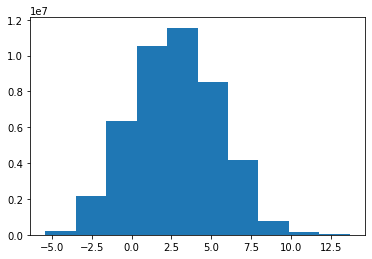

In [146]:
plt.hist(onp.log10(SEDs['spire_250']))